In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import plotly.express as px
import IPython.display as display
import imageio
#import xarray as xr # potentially useful
#import geopandas as gpd # might be useful for created US map graphs

#### Upload demand log data and refine out the random times (can take a while to run)

In [37]:
# dataframe for demand log
df_demand_log = pd.read_excel('FruitSoul Demand Log Fixed.xlsx')
df_demand_log['Earliest Delivery Date'] = df_demand_log['Earliest Delivery Date'].dt.date
df_demand_log['Preferred Delivery Date'] = df_demand_log['Preferred Delivery Date'].dt.date
df_demand_log['Latest Delivery Date'] = df_demand_log['Latest Delivery Date'].dt.date
df_demand_log_temp = df_demand_log.copy()
df_demand_log

,DemandID,Demand Request Date,Mix,Jar Size (vol. ounces),State,Quantity,Earliest Delivery Date,Preferred Delivery Date,Latest Delivery Date
0,1,2021-01-01,Apple-Mango,8,Maryland,1,2021-01-01,2021-01-04,2021-01-07
1,2,2021-01-01,Blueberry-Lemon,32,Kentucky,1,2021-01-04,2021-01-06,2021-01-09
2,3,2021-01-01,Orange-Passionfruit,16,Minnesota,1,2021-01-07,2021-01-10,2021-01-11
3,4,2021-01-01,Orange-Passionfruit,16,California,1,2021-01-07,2021-01-11,2021-01-14
4,5,2021-01-01,Orange-Passionfruit,32,Louisiana,1,2021-01-01,2021-01-04,2021-01-10
...,...,...,...,...,...,...,...,...,...
835374,835375,2023-12-31,Orange-Passionfruit,32,Arizona,1,2023-12-31,2024-01-05,2024-01-13
835375,835376,2023-12-31,Peach-Raspberry,32,California,1,2023-12-31,2024-01-01,2024-01-01
835376,835377,2023-12-31,Blueberry-Lemon,16,Arizona,1,2023-12-31,2024-01-02,2024-01-02
835377,835378,2023-12-31,Strawberry-Kiwi,8,California,1,2023-12-31,2024-01-03,2024-01-03


# Demand Request Date graphs

#### Total quantity by demand request date

Total quantity: 859121


<Axes: xlabel='Demand Request Date'>

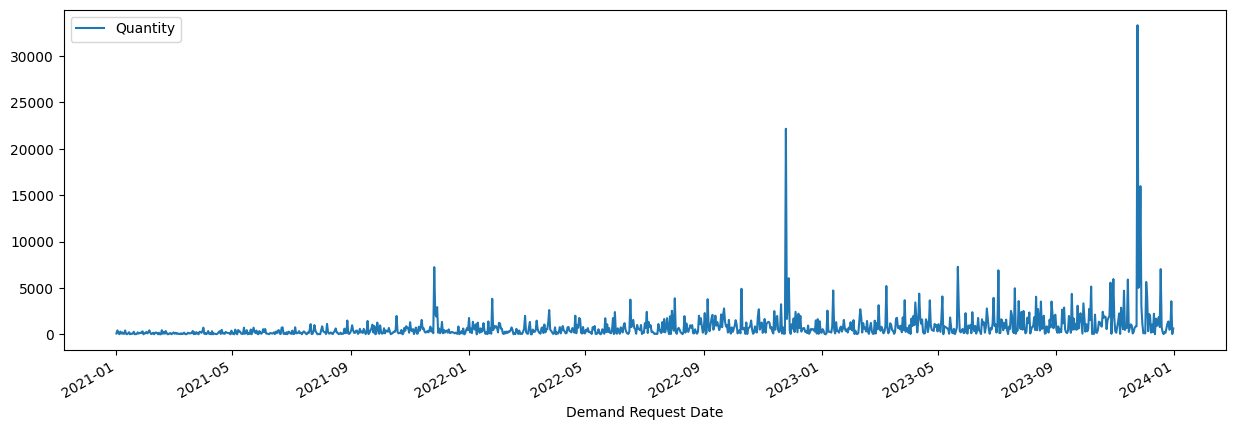

In [54]:
# Make a pivot table for over demand request date
pivot_demand_request_date = df_demand_log.pivot_table(index='Demand Request Date', 
                                        values='Quantity', aggfunc='sum', fill_value=0)

total_quantity = pivot_demand_request_date['Quantity'].sum()
print(f'Total quantity: {total_quantity}')

pivot_demand_request_date.plot(kind='line', figsize=(15, 5))

#### Daily demand request date for each mix and jar size (country aggregated)

In [55]:
# Make a pivot table for over demand request date
pivot_demand_request_date_by_mix = df_demand_log.pivot_table(index='Demand Request Date', 
                                        columns=['Mix', 'Jar Size  (vol. ounces)'], 
                                        values='Quantity', aggfunc='sum', fill_value=0)

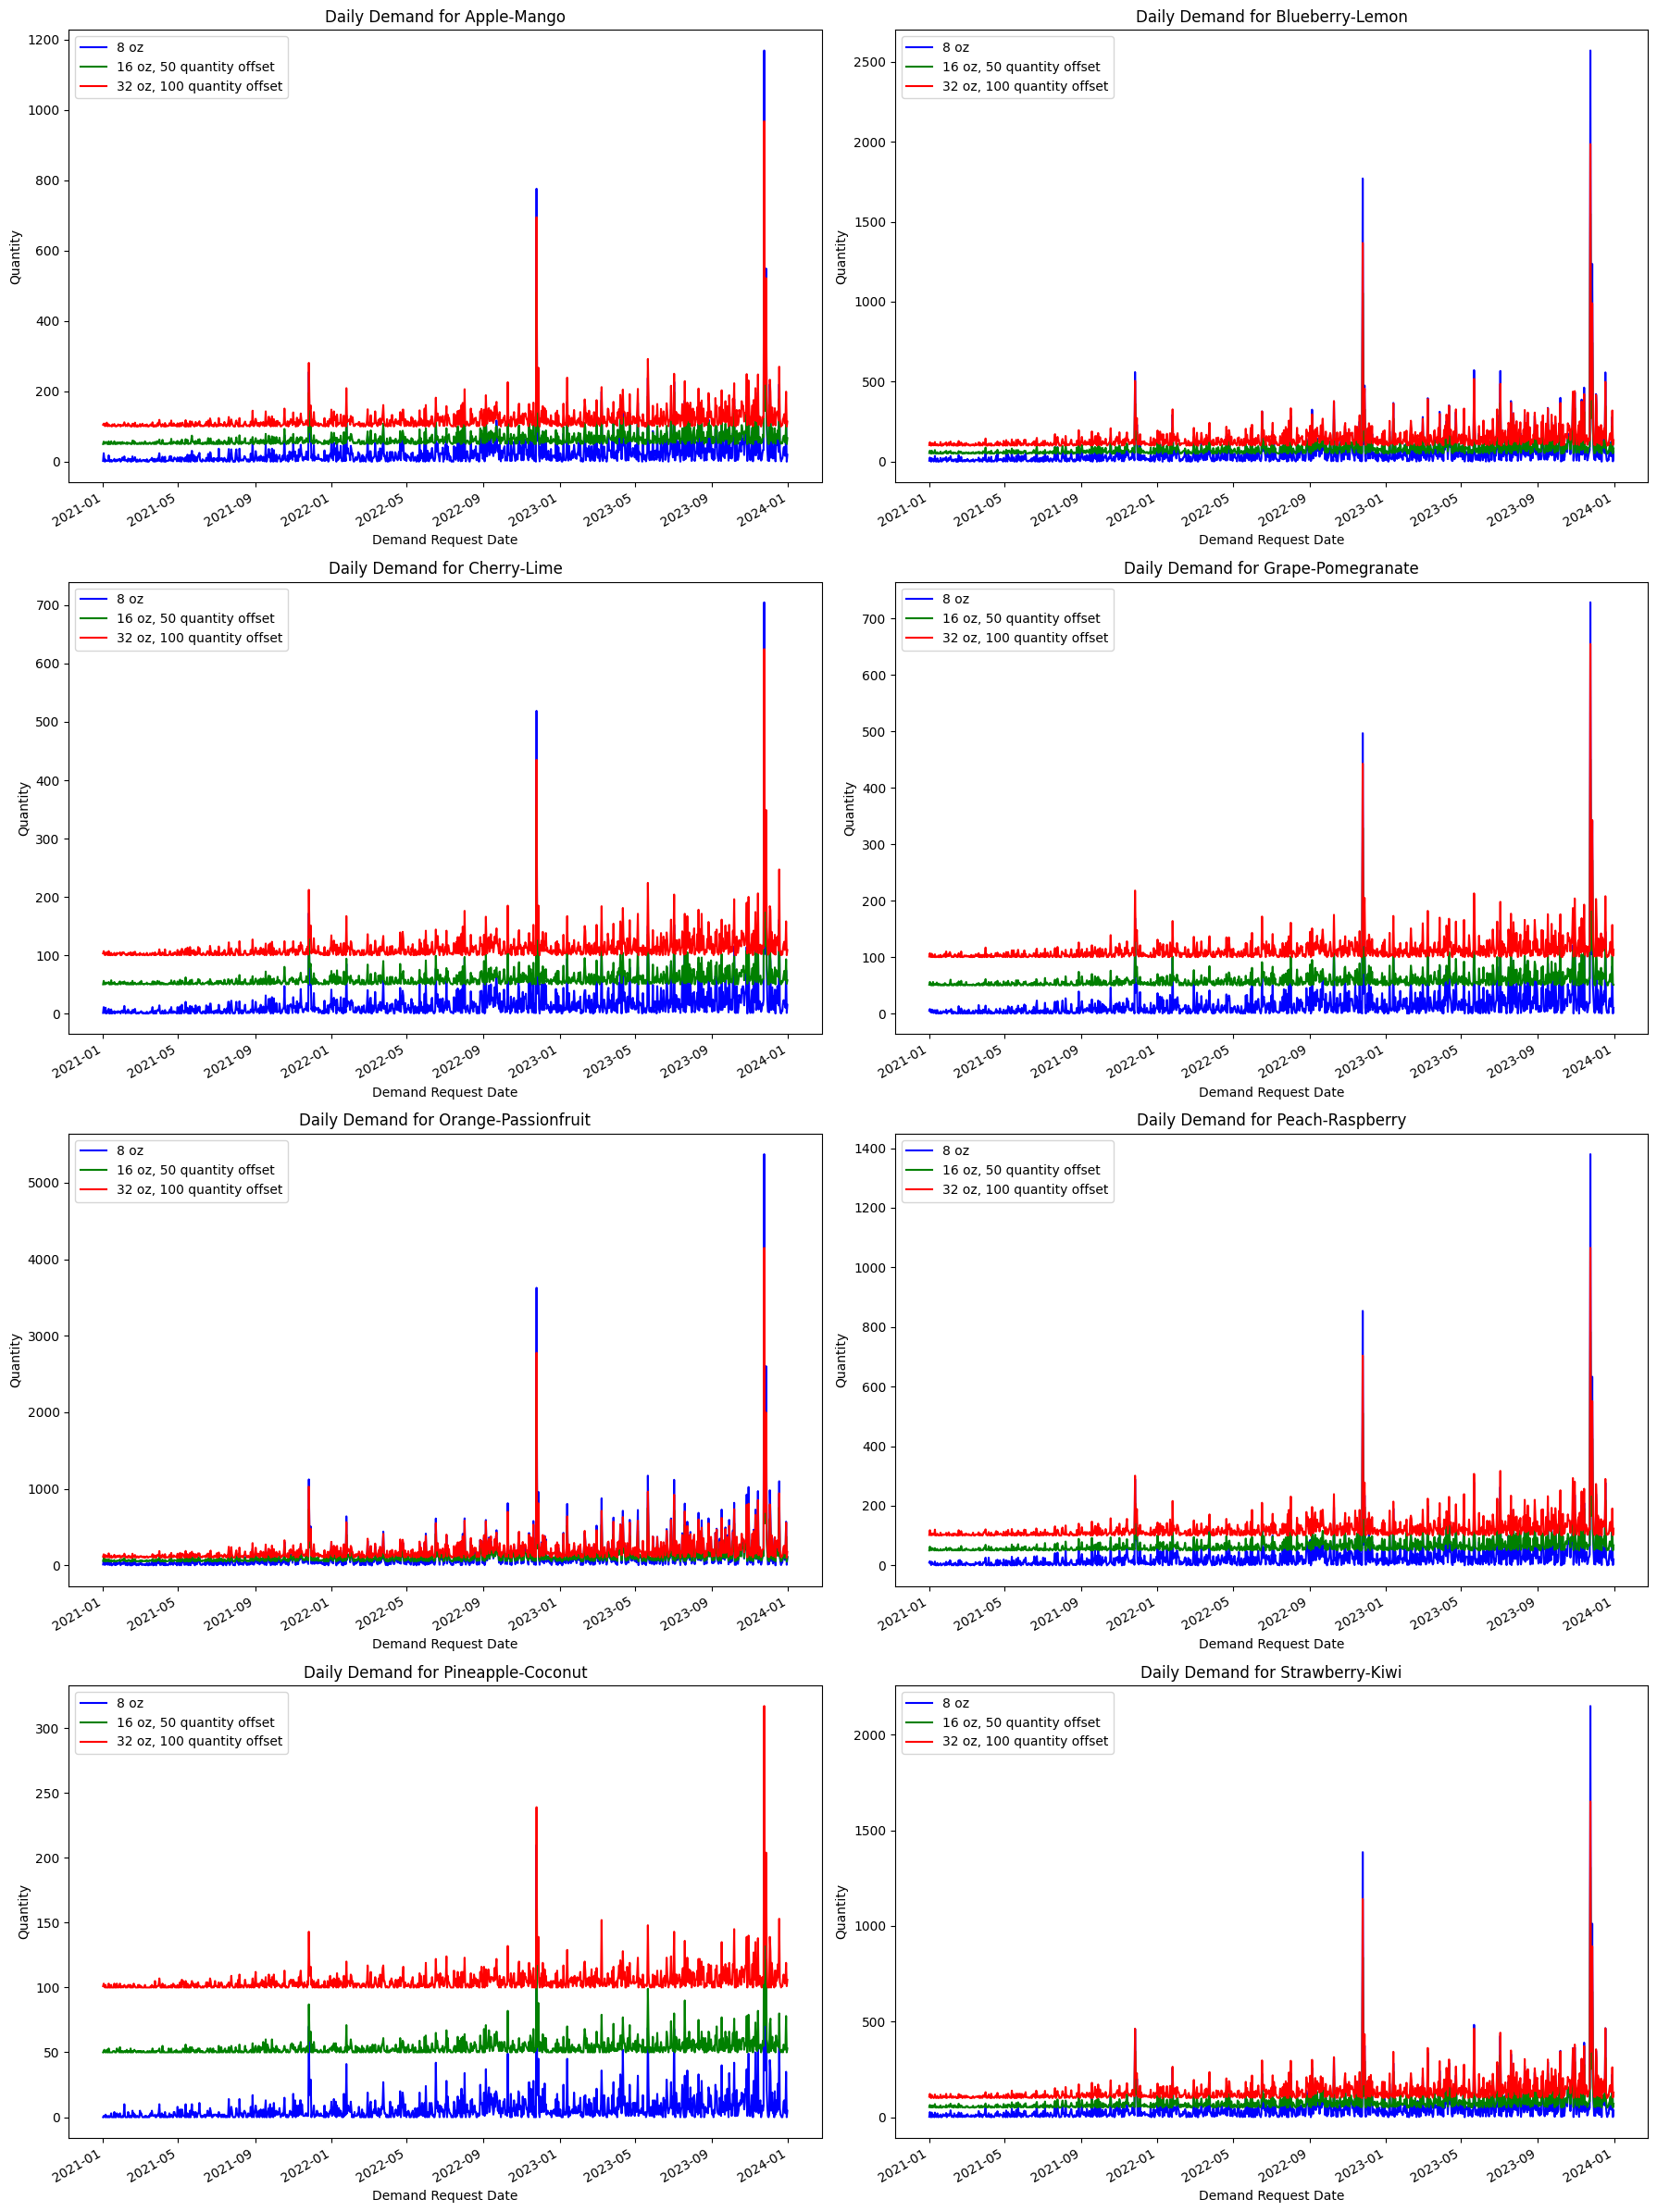

In [56]:
# Create the subplots with a 4x2 structure
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 24))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Define colors for each jar size
colors = ['blue', 'green', 'red']

i = 0
for n, mix in enumerate(pivot_demand_request_date_by_mix.columns.levels[0]):
    # Plot with vertical offsets and specified colors
    pivot_demand_request_date_by_mix[(mix, 8)].add(0).plot(ax=axes[i], label='8 oz', color=colors[0])
    pivot_demand_request_date_by_mix[(mix, 16)].add(50).plot(ax=axes[i], label='16 oz, 50 quantity offset', color=colors[1])
    pivot_demand_request_date_by_mix[(mix, 32)].add(100).plot(ax=axes[i], label='32 oz, 100 quantity offset', color=colors[2])

    # Add labels and title
    axes[i].set_xlabel('Demand Request Date')
    axes[i].set_ylabel('Quantity')
    axes[i].set_title(f'Daily Demand for {mix}')
    axes[i].legend()
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### Quantity of mix and jar size by demand request date, on a weekly basis (for clarity)

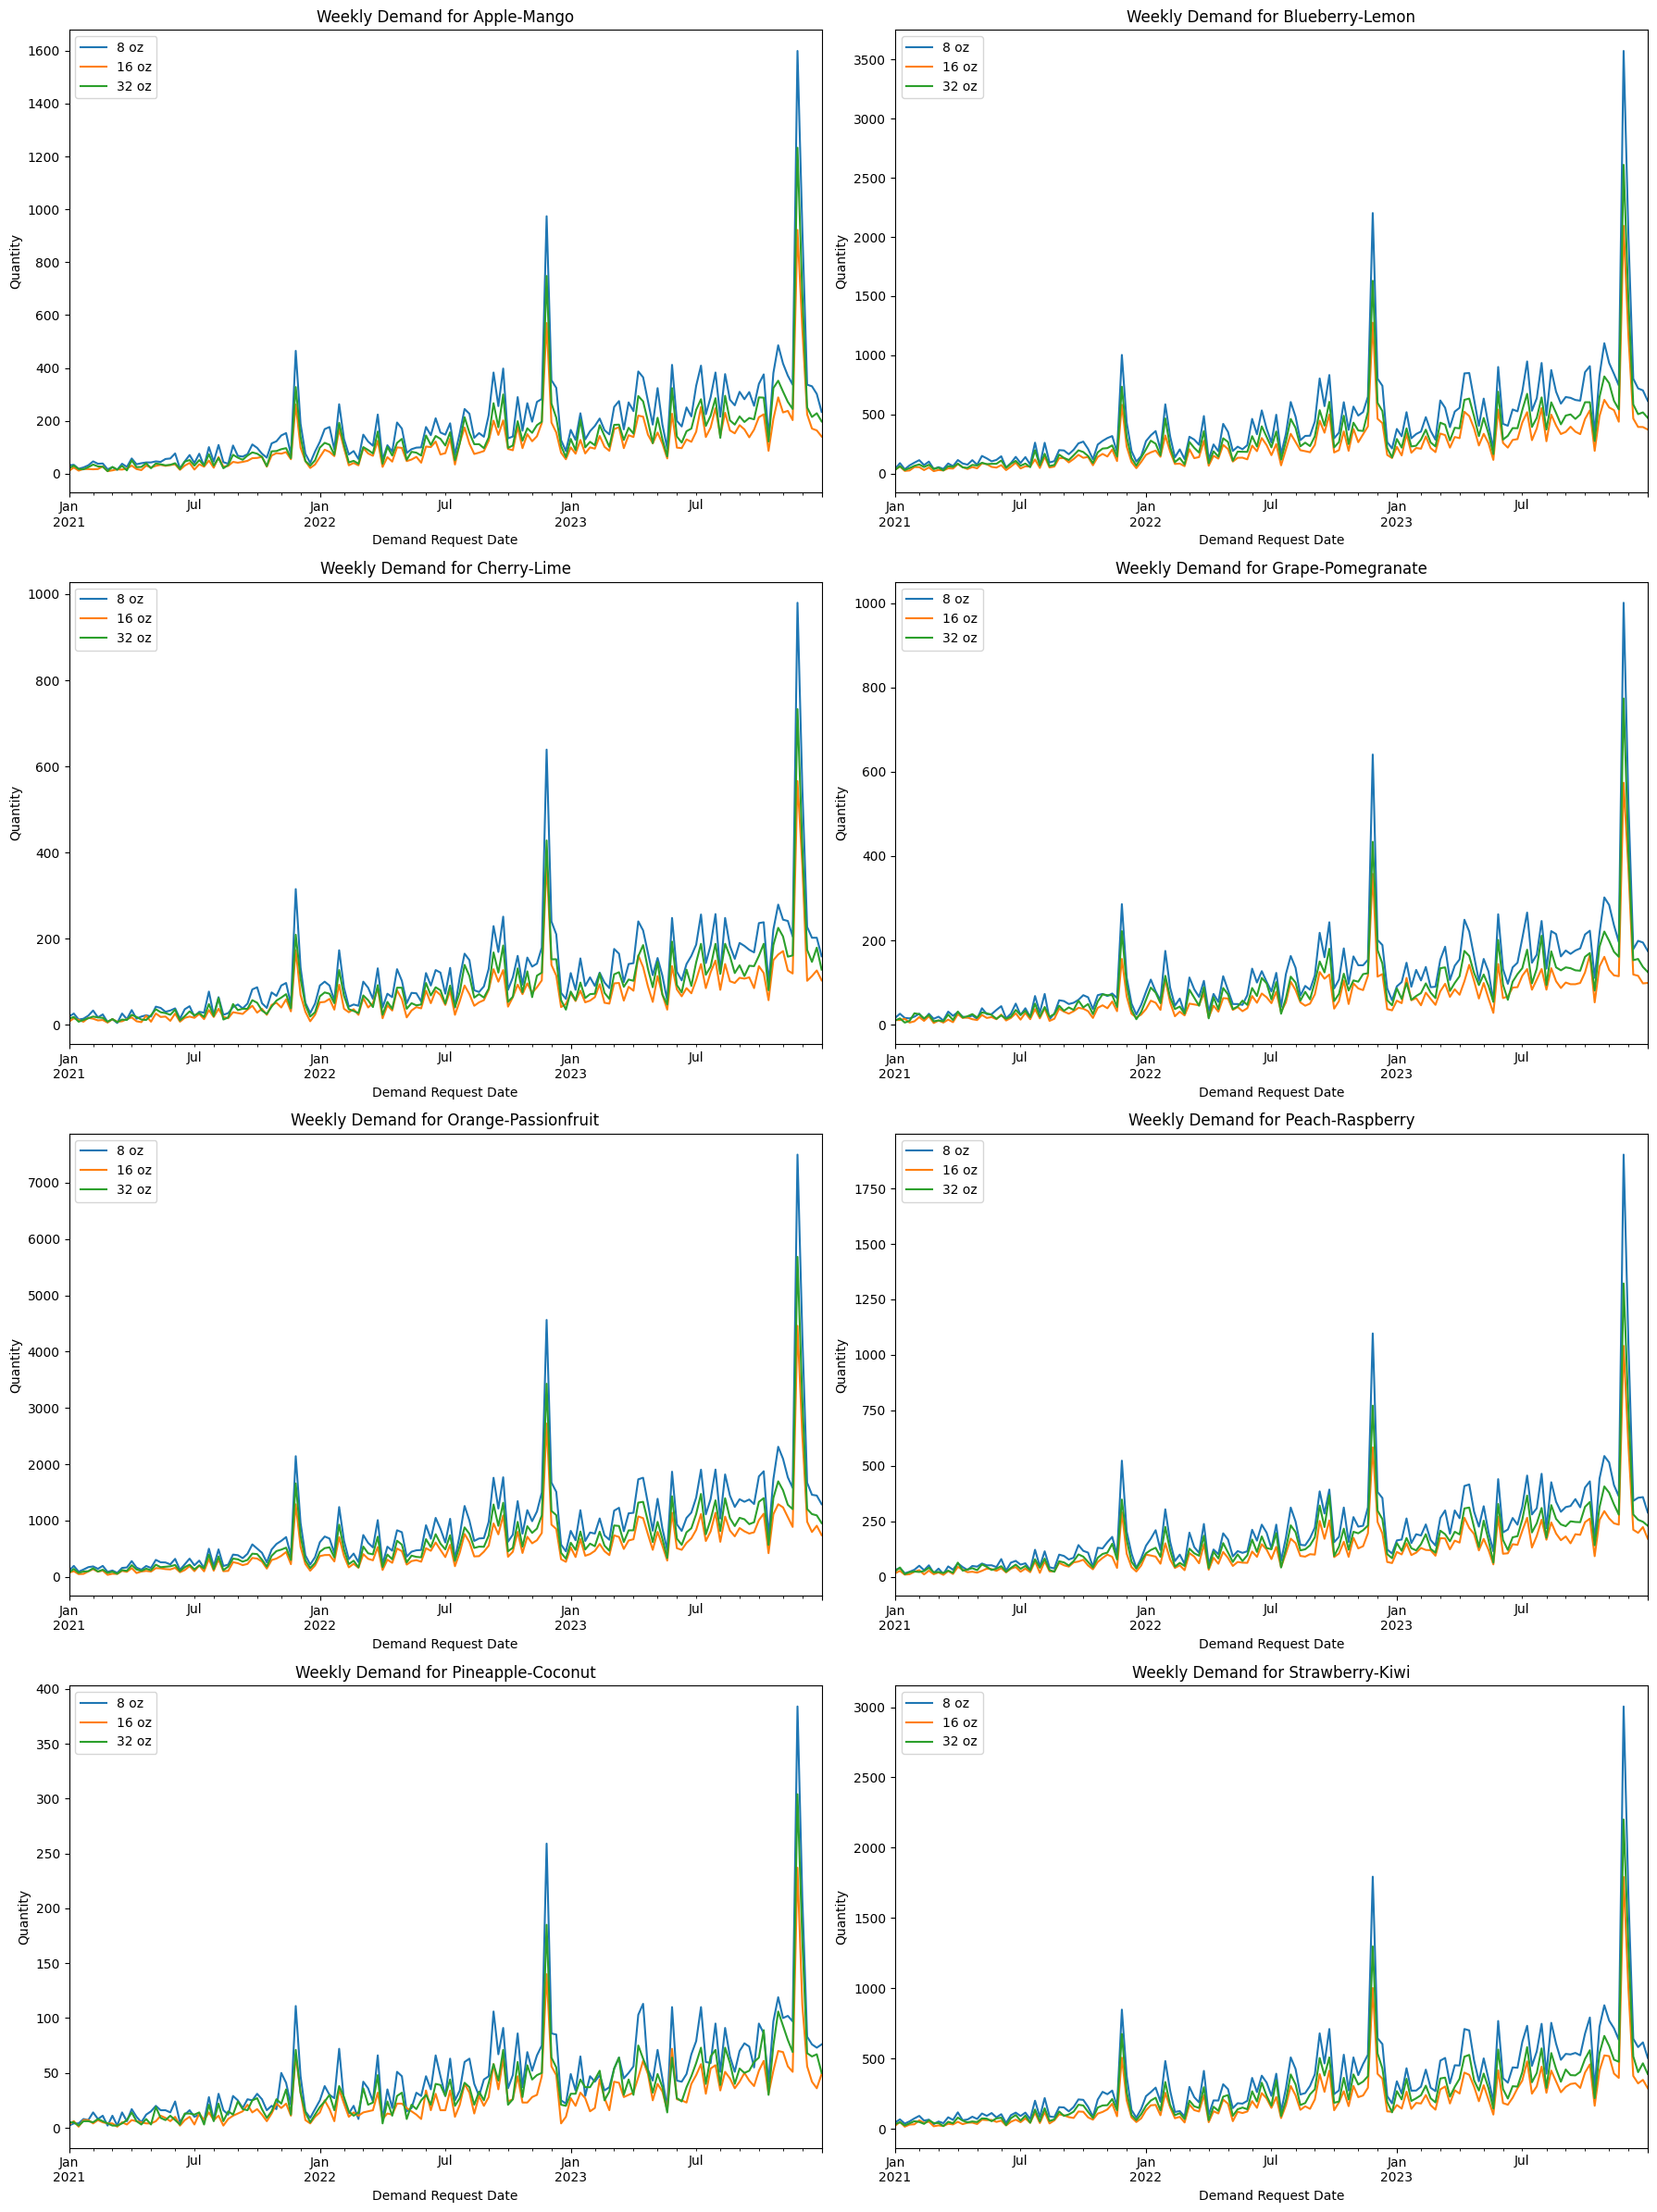

In [57]:
# Resample the pivot table to weekly
pivot_demand_request_date_by_mix_weekly = pivot_demand_request_date_by_mix.resample('W').sum()

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 24))

# Flatten the axes array for easy iteration
axes = axes.flatten()

i = 0
for n, mix in enumerate(pivot_demand_request_date_by_mix_weekly.columns.levels[0]):
    # Plot
    pivot_demand_request_date_by_mix_weekly[(mix, 8)].plot(ax=axes[i], label='8 oz')
    pivot_demand_request_date_by_mix_weekly[(mix, 16)].plot(ax=axes[i], label='16 oz')
    pivot_demand_request_date_by_mix_weekly[(mix, 32)].plot(ax=axes[i], label='32 oz')

    # Add labels and title
    axes[i].set_xlabel('Demand Request Date')
    axes[i].set_ylabel('Quantity')
    axes[i].set_title(f'Weekly Demand for {mix}')
    axes[i].legend()
    i += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### Total Demand by states, ordered by total quantitiy from least to greatest (not clear)

We could make a states map graph (as he showed in the lecture) instead of a line graph, but I'm having issues making geopandas work.

In [58]:
# Create a pivot table indexed by demand request date with all states
pivot_demand_request_date_states = df_demand_log.pivot_table(index='Demand Request Date', 
                                                             columns='State', 
                                                             values='Quantity', 
                                                             aggfunc='sum', 
                                                             fill_value=0)

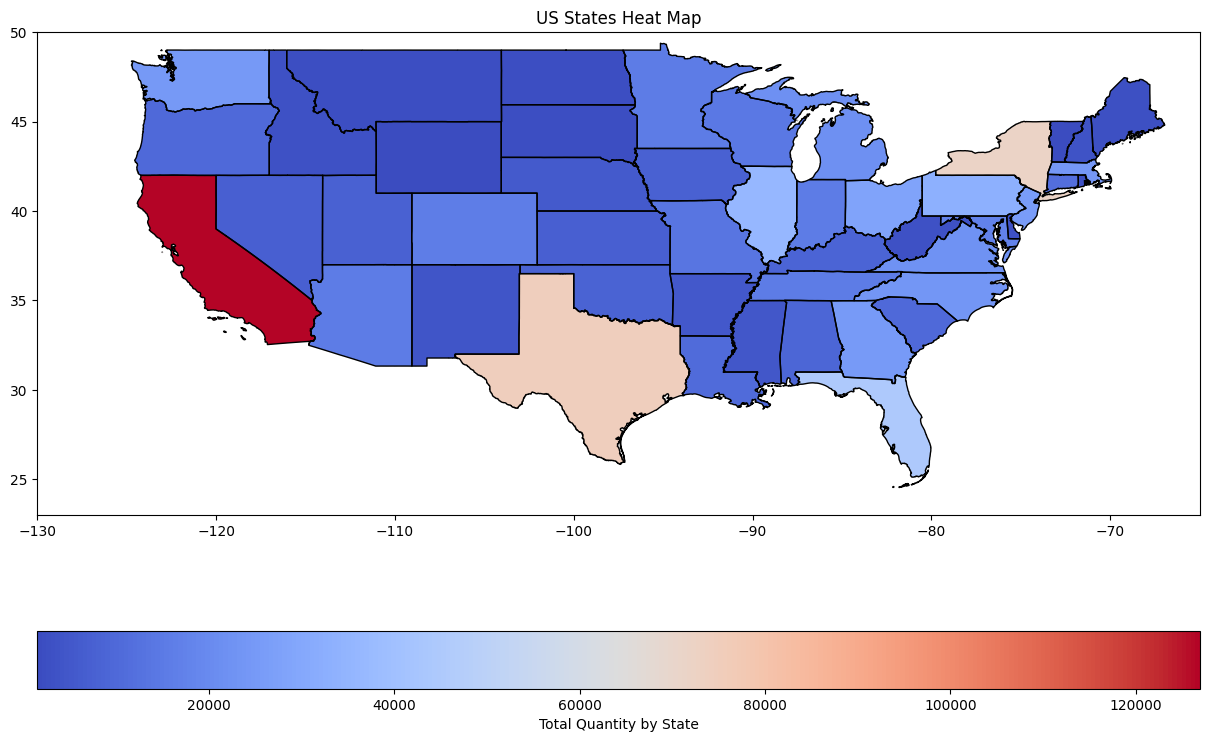

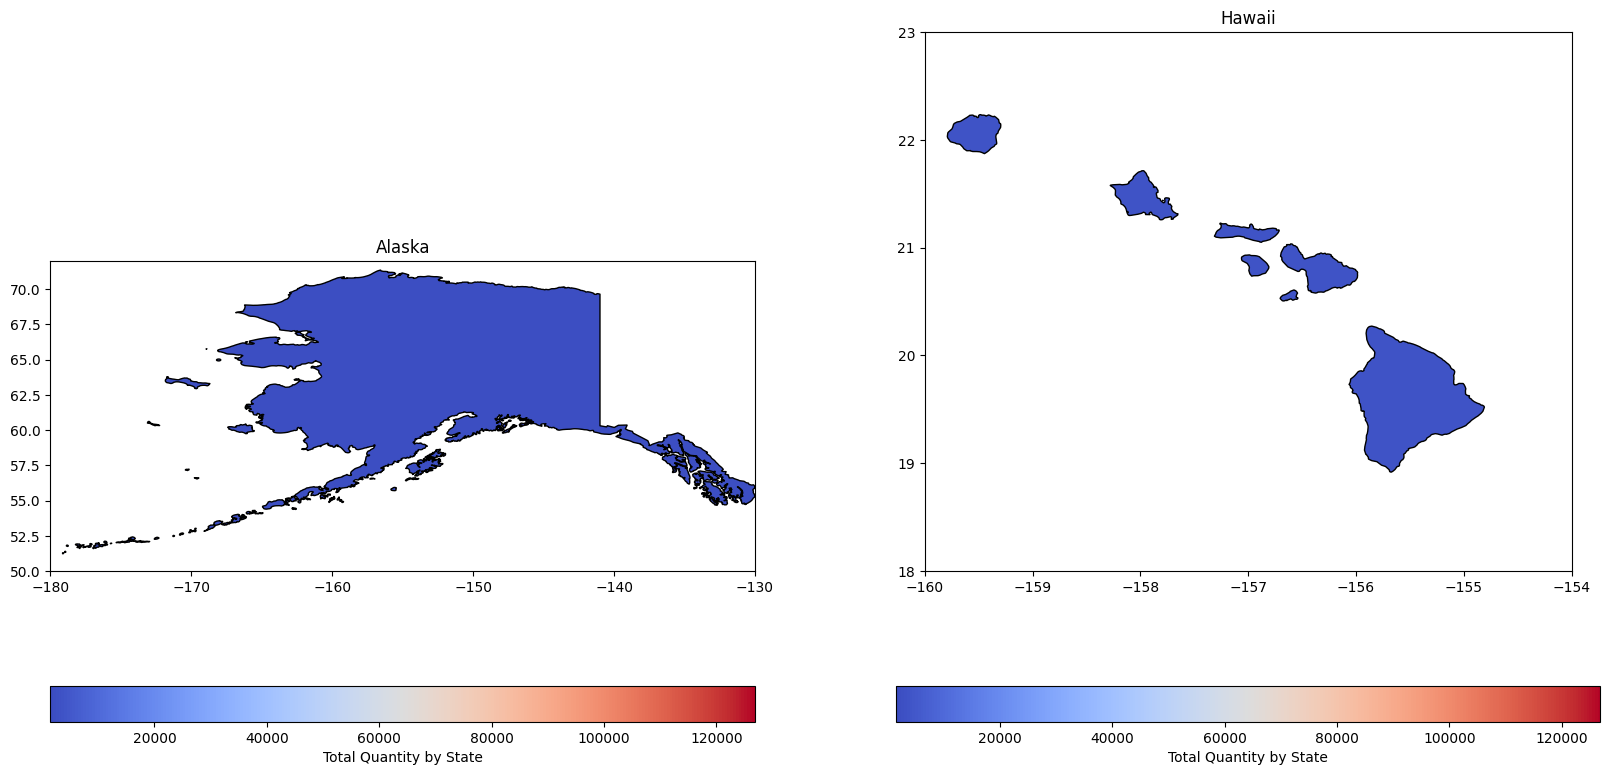

In [59]:
df_states = geopandas.read_file('st99_d00.shp')
df_states.rename(columns={'STATE':'StateID'}, inplace=True)
df_states = df_states.rename(columns={'NAME':'State'}) 
pivot_demand_states = df_demand_log.pivot_table(index='State', 
                                                columns='Demand Request Date', 
                                                values='Quantity', 
                                                aggfunc='sum',
                                                fill_value=0)
pivot_demand_states['Total'] = pivot_demand_states.sum(axis=1)
pivot_demand_states.reset_index()
df_states_merged = pd.merge(df_states, pivot_demand_states, on='State', how='left')
alaska = df_states[df_states['State'] == 'AK']
hawaii = df_states[df_states['State'] == 'HI']

fig, ax0 = plt.subplots(1, 1, figsize=(15, 10))
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(20, 10))

df_states.boundary.plot(ax=ax0, linewidth=1, color='black')  # Outline of states
df_states_merged.plot(column='Total', ax=ax0, legend=True,
               legend_kwds={'label': "Total Quantity by State",
                            'orientation': "horizontal"},
               cmap='coolwarm')
ax0.set_xlim(-130, -65)
ax0.set_ylim(23,50)
ax0.set_title('US States Heat Map')

df_states.boundary.plot(ax=ax2, linewidth=1, color='black')
df_states_merged.plot(column='Total', ax=ax2, legend=True,
               legend_kwds={'label': "Total Quantity by State",
                            'orientation': "horizontal"},
               cmap='coolwarm')
ax2.set_title('Alaska')
ax2.set_xlim(-180, -130)
ax2.set_ylim(50, 72)

df_states.boundary.plot(ax=ax1, linewidth=1, color='black')
df_states_merged.plot(column='Total', ax=ax1, legend=True,
               legend_kwds={'label': "Total Quantity by State",
                            'orientation': "horizontal"},
               cmap='coolwarm') 
ax1.set_title('Hawaii')
ax1.set_xlim(-160, -154)
ax1.set_ylim(18, 23)
plt.show()

/var/folders/70/hwzrby3n729d5jwzx9zt1h080000gn/T/ipykernel_21993/485615306.py:14: FutureWarning: DataFrame.resample with axis=1 is deprecated. Do `frame.T.resample(...)` without axis instead.
  Quarterly_average_state_shares = pivot_state_demand_share.resample('QE', axis=1).mean()
/var/folders/70/hwzrby3n729d5jwzx9zt1h080000gn/T/ipykernel_21993/485615306.py:42: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'images/plot_{i}.png'))


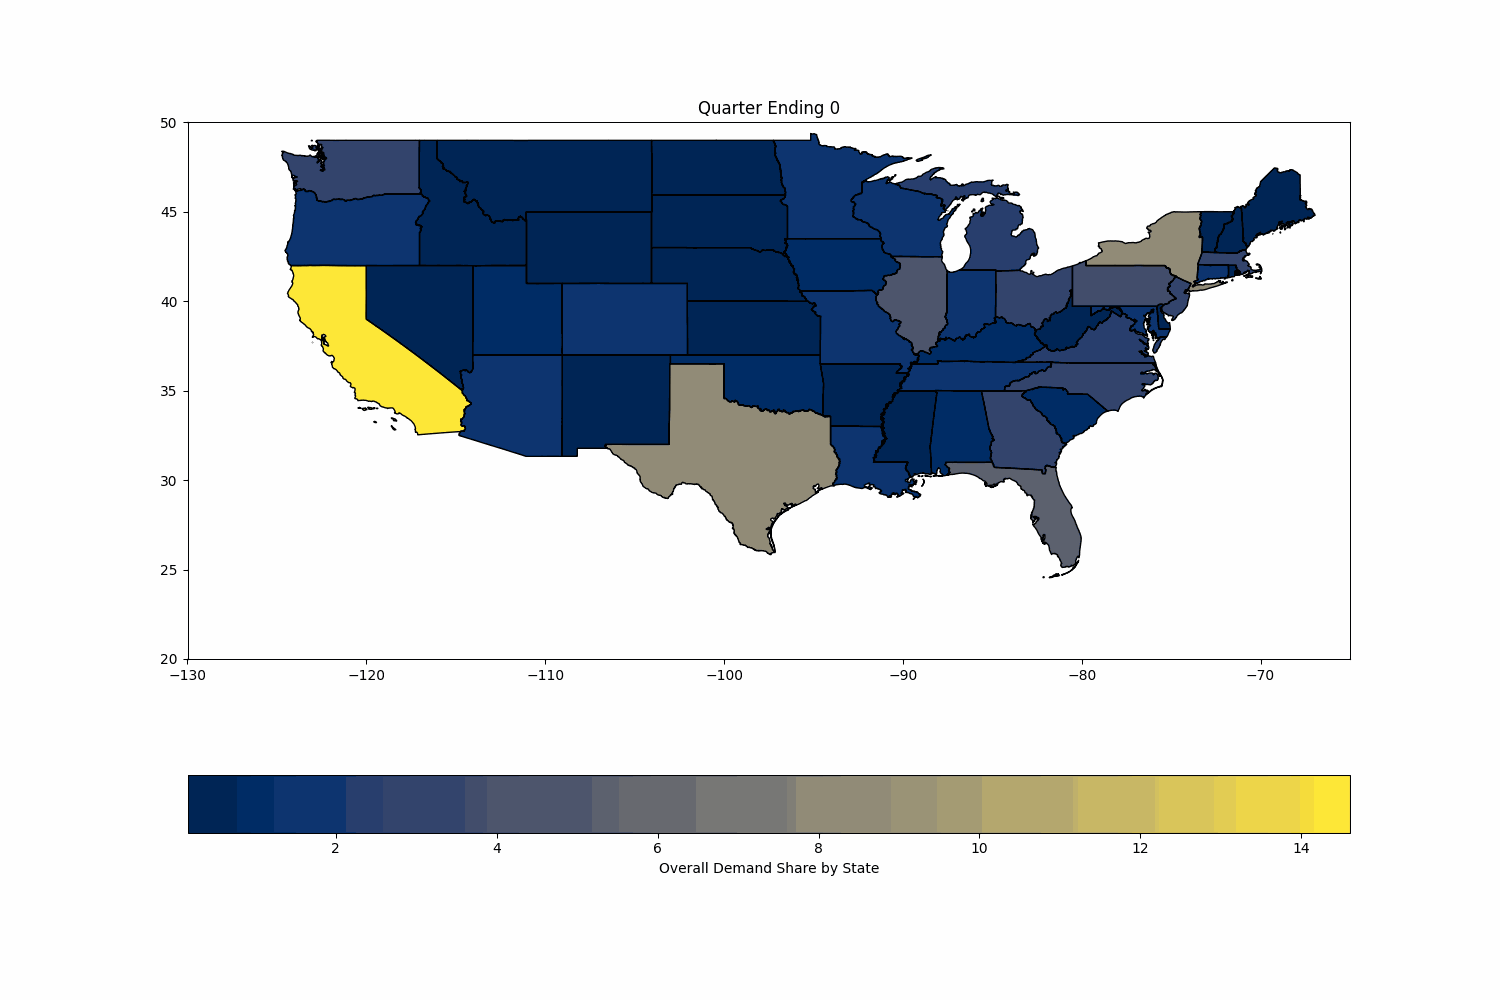

In [60]:
df_states = geopandas.read_file('st99_d00.shp')
df_states.rename(columns={'STATE':'StateID', 'NAME':'State'}, inplace=True)
pivot_demand_states = df_demand_log.pivot_table(index='State', 
                                                columns='Demand Request Date', 
                                                values='Quantity', 
                                                aggfunc='sum',
                                                fill_value=0)
pivot_state_demand_share = pivot_demand_states.div(pivot_demand_states.sum(axis=0), axis=1) * 100
pivot_demand_states.reset_index()
df_states_merged = pd.merge(df_states, pivot_demand_states, on='State', how='left')

pivot_state_demand_share.columns = pd.to_datetime(pivot_state_demand_share.columns)

Quarterly_average_state_shares = pivot_state_demand_share.resample('QE', axis=1).mean()
pivot_state_demand_share['Average'] = Quarterly_average_state_shares.mean(axis=1).values
# Align the 'Average' column with the 'State' column in df_states_merged
df_states_merged = df_states_merged.set_index('State').join(pivot_state_demand_share, rsuffix='_share').reset_index()

# Create a directory to save the images
if not os.path.exists('images'):
    os.makedirs('images')

# Generate plots for each quarter
for i, (date, column) in enumerate(Quarterly_average_state_shares.items()):
    fig, ax0 = plt.subplots(1, 1, figsize=(15, 10))  # Create a new figure and axis

    df_states.boundary.plot(ax=ax0, linewidth=1, color='black')  # Outline of states
    df_states_merged.plot(column='Average', ax=ax0, legend=True,
                     legend_kwds={'label': "Overall Demand Share by State",
                                  'orientation': "horizontal"},
                          cmap='cividis')
    ax0.set_xlim([-130, -65])
    ax0.set_ylim([20, 50])
    plt.title(f'Quarter Ending {i}')
    plt.savefig(f'images/plot_{i}.png')
    plt.close()

    
# Get list of image files
images = []
for i in range(len(Quarterly_average_state_shares.columns)):
    images.append(imageio.imread(f'images/plot_{i}.png'))

# Create GIF
gif_path = 'quarterly_data.gif'
imageio.mimsave('quarterly_data.gif', images, duration=2)

# Display the GIF
import IPython.display as display
display.Image(filename=gif_path)

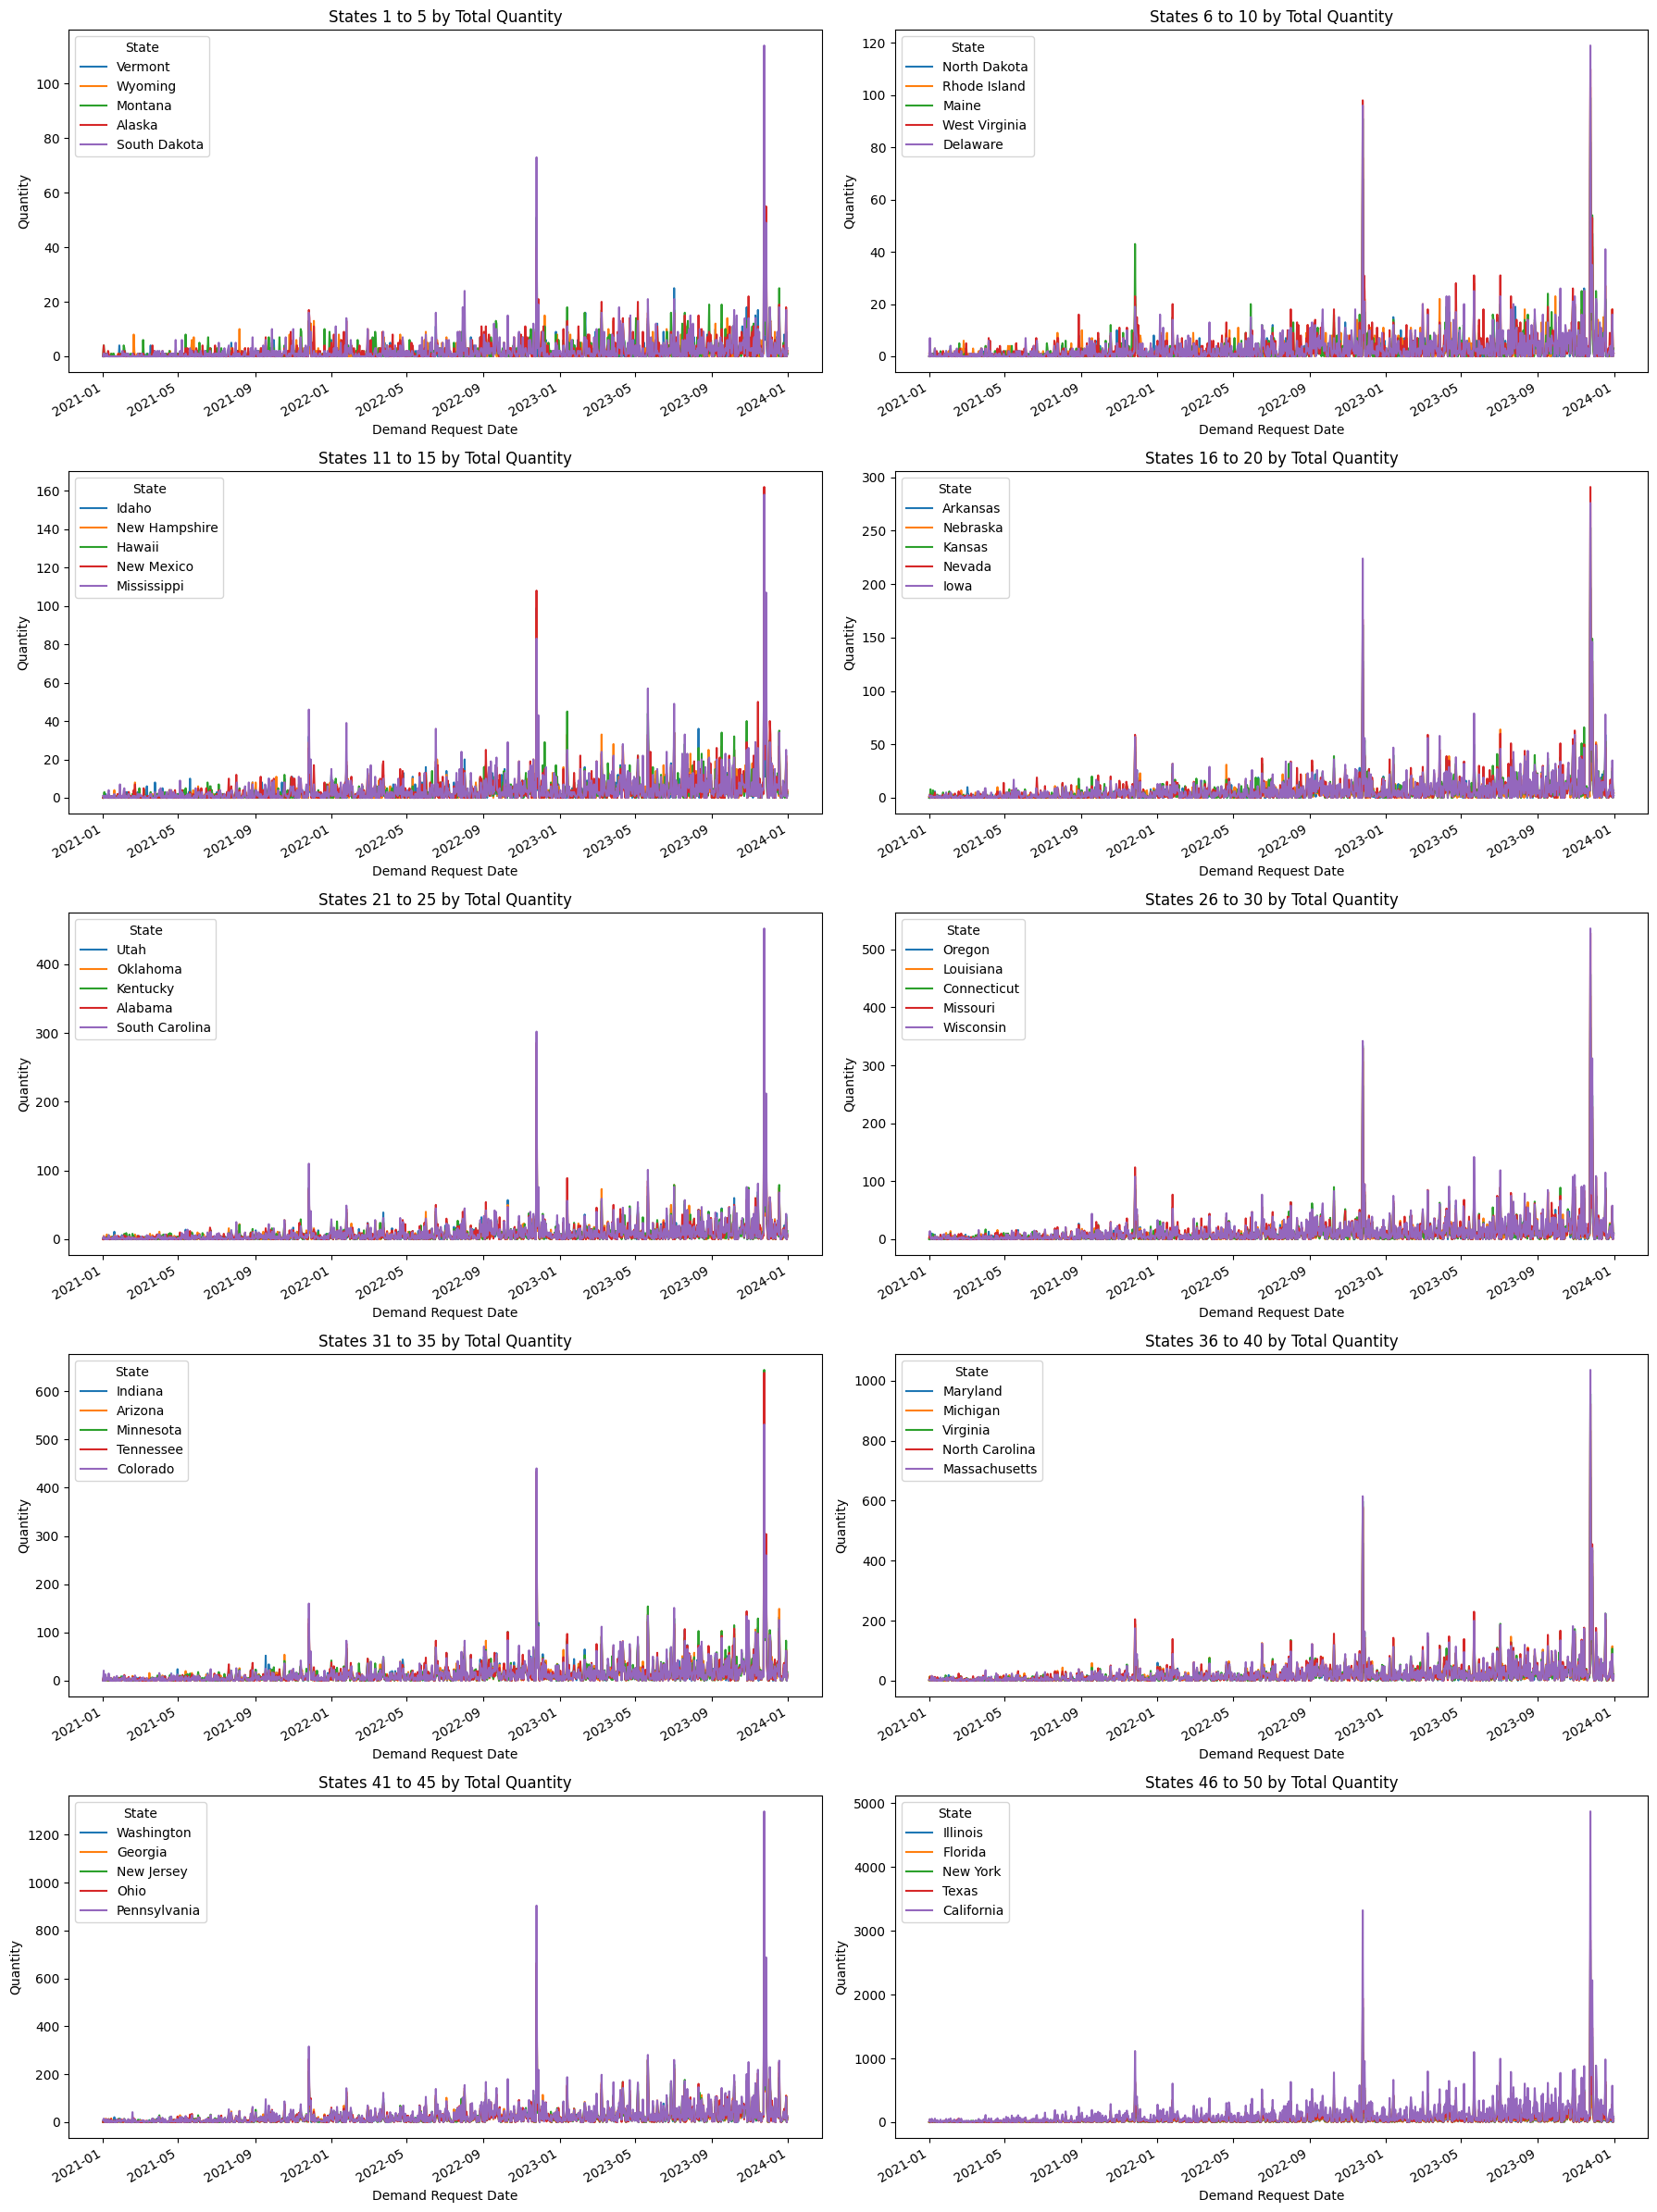

In [61]:
# Calculate the total quantity for each state
total_quantity_by_state = pivot_demand_request_date_states.sum()

# Sort the states by total quantity
sorted_states = total_quantity_by_state.sort_values()

# Split the sorted states into chunks of 5
state_chunks = [sorted_states[i:i + 5].index for i in range(0, len(sorted_states), 5)]

# Create the subplots with a 5x2 structure
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(18, 24))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each chunk of states
for i, chunk in enumerate(state_chunks):
    pivot_demand_request_date_states[chunk].plot(ax=axes[i])
    axes[i].set_title(f'States {i*5+1} to {i*5+5} by Total Quantity')
    axes[i].set_xlabel('Demand Request Date')
    axes[i].set_ylabel('Quantity')
    axes[i].legend(title='State')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

#### Average demand per day over states

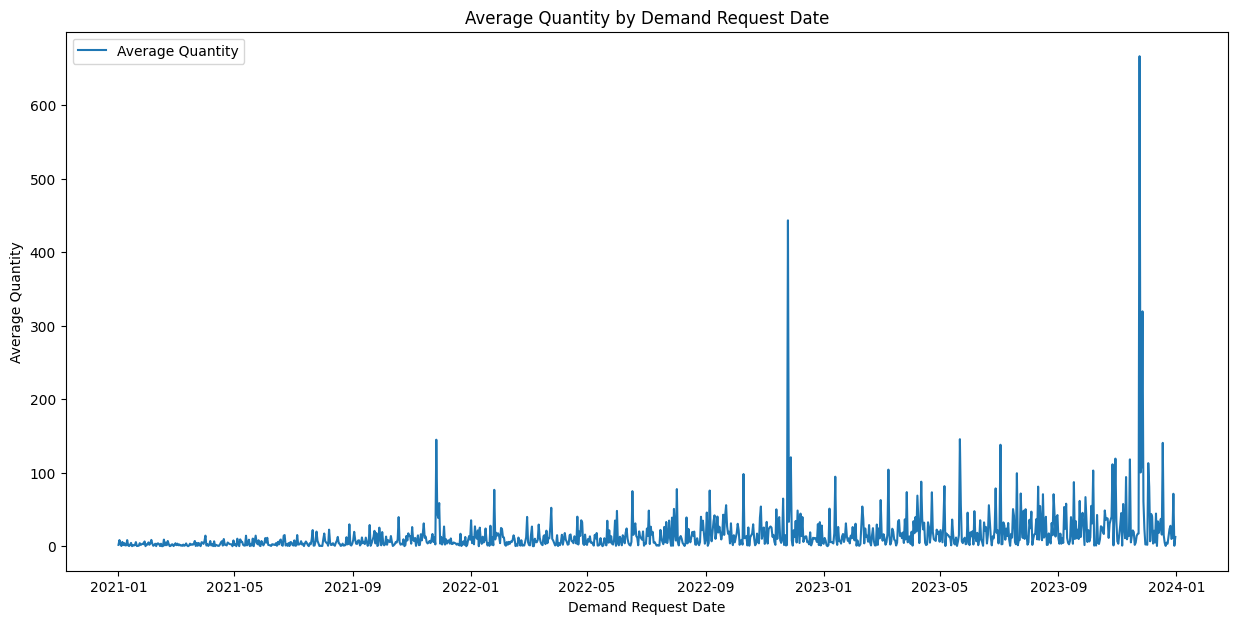

In [62]:


#pivot_demand_request_date_states
pivot_demand_request_date_states['Average'] = pivot_demand_request_date_states.mean(axis=1)

# Plot demand request date on the x-axis and average on the y-axis
plt.figure(figsize=(15, 7))
plt.plot(pivot_demand_request_date_states.index, pivot_demand_request_date_states['Average'], label='Average Quantity')
plt.xlabel('Demand Request Date')
plt.ylabel('Average Quantity')
plt.title('Average Quantity by Demand Request Date')
plt.legend()
plt.show()

#### Preferred, Earliest, and Latest demand graphs and smoothing

The graph below shows that the latest delivery date is much smoother (flatter) than the earliest and preferred (average quantity being the absolute, but impossible, smoothest). The question is can we use the range of dates to smooth the graph even further? As long as items are delivered in the time window, then we have satisfied customer demand.

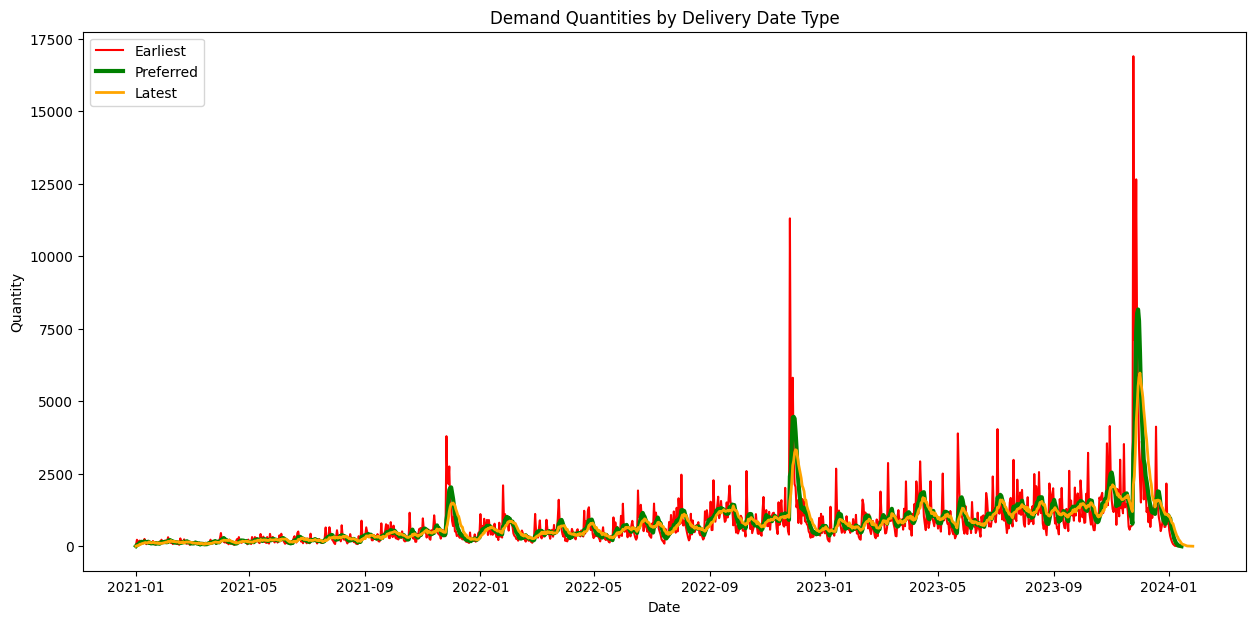

In [63]:
# Create a pivot table indexed by preferred delivery date
pivot_preferred_delivery_date = df_demand_log.pivot_table(index='Preferred Delivery Date', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_earliest_delivery_date = df_demand_log.pivot_table(index='Earliest Delivery Date', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

pivot_latest_delivery_date = df_demand_log.pivot_table(index='Latest Delivery Date', 
                                                        values='Quantity',
                                                        aggfunc='sum', 
                                                        fill_value=0)

# Plot all three pivot tables on the same graph
plt.figure(figsize=(15, 7))
plt.plot(pivot_earliest_delivery_date.index, pivot_earliest_delivery_date['Quantity'], label='Earliest', color='r')
plt.plot(pivot_preferred_delivery_date.index, pivot_preferred_delivery_date['Quantity'], label='Preferred', linewidth=3, color="g")
plt.plot(pivot_latest_delivery_date.index, pivot_latest_delivery_date['Quantity'], label='Latest', linewidth=2, color='orange')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Demand Quantities by Delivery Date Type')
plt.legend()
plt.show()

This code plots the total, yearly, and quarterly averages against the latest demand.

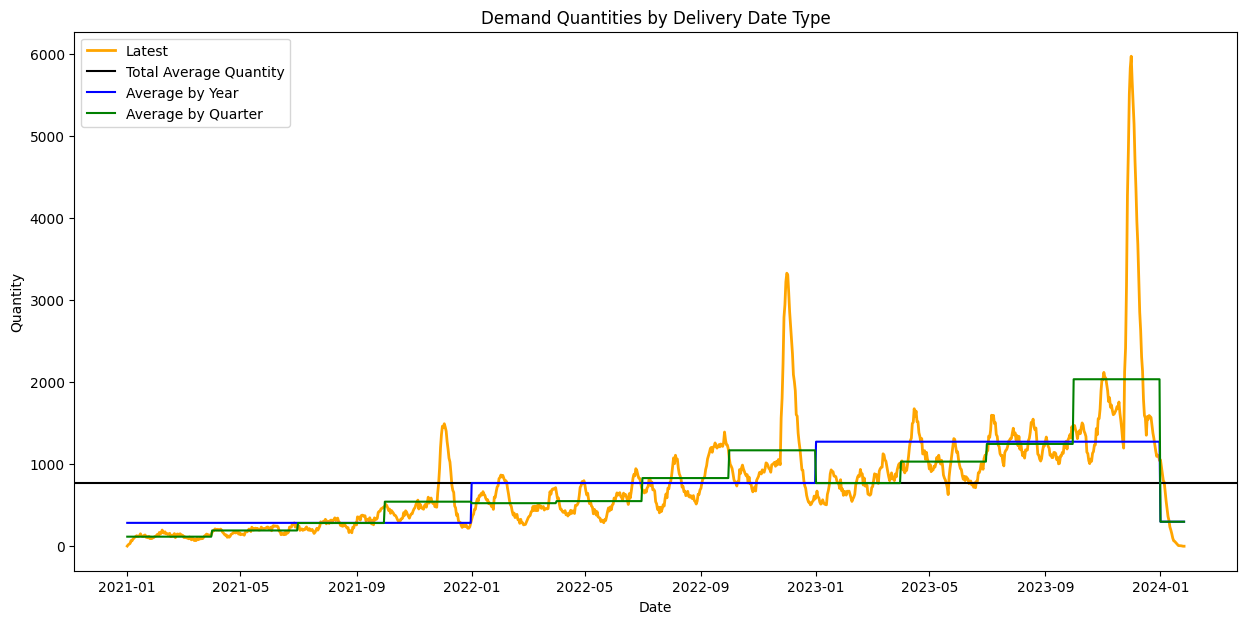

In [64]:
# Convert index to DatetimeIndex
pivot_latest_delivery_date_temp = pivot_latest_delivery_date.copy()
pivot_latest_delivery_date_temp.index = pd.to_datetime(pivot_latest_delivery_date.index)

# Calculate the average quantity for the latest delivery date and note the last day
total_average_quantity = pivot_latest_delivery_date['Quantity'].mean()
last_day = pivot_latest_delivery_date_temp.index[-1]

# Calculate the average quantity for each year and match the last day
average_quantity_by_year = pivot_latest_delivery_date_temp.resample('YE').mean()
average_quantity_by_year.index = average_quantity_by_year.index[:-1].append(pd.to_datetime([last_day]))

# Refine average quantity by year to make a proper line plot
for i in average_quantity_by_year.index:
    year = pd.to_datetime(f'{i.year}-01-01')
    new_row = pd.DataFrame({'Quantity': [average_quantity_by_year.loc[i, 'Quantity']]}, index=[year])
    average_quantity_by_year = pd.concat([average_quantity_by_year, new_row]).sort_index()

# Calculate the average quantity for each quarter
average_quantity_by_quarter = pivot_latest_delivery_date_temp.resample('QE').mean()

# Refine average quantity by quarter to make a proper line plot
for i in average_quantity_by_quarter.index:
    three_months_prior = (i - pd.DateOffset(months=2)).month
    year_month = pd.to_datetime(f'{i.year}-{three_months_prior}-01')
    new_row = pd.DataFrame({'Quantity': [average_quantity_by_quarter.loc[i, 'Quantity']]}, index=[year_month])
    average_quantity_by_quarter = pd.concat([average_quantity_by_quarter, new_row]).sort_index()

average_quantity_by_quarter.index = average_quantity_by_quarter.index[:-1].append(pd.to_datetime([last_day]))

plt.figure(figsize=(15, 7))

plt.plot(pivot_latest_delivery_date.index, pivot_latest_delivery_date['Quantity'], label='Latest', linewidth=2, color='orange')
plt.axhline(y=total_average_quantity, color='black', label='Total Average Quantity')
plt.plot(average_quantity_by_year.index, average_quantity_by_year['Quantity'], label='Average by Year', color='b')
plt.plot(average_quantity_by_quarter.index, average_quantity_by_quarter['Quantity'], label='Average by Quarter', color='g')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Demand Quantities by Delivery Date Type')
plt.legend()
plt.show()

The goal of this code is to average every demand request date's quantity order over the range of earliest to latest delivery dates.

Note: this code can take a while to run.

In [49]:
# Expand the dataframe to include all dates in the range from the earliest to the latest delivery date
expanded_rows = []

# Iterate over the rows of the original DataFrame
for _, row in df_demand_log.iterrows():
    start_date = row['Earliest Delivery Date']
    end_date = row['Latest Delivery Date']
    quantity = row['Quantity']
    
    # Generate date range as a list
    date_range = pd.date_range(start=start_date, end=end_date)
    
    # Calculate the quantity to be distributed to each date
    daily_quantity = quantity / len(date_range)
    
    # Iterate over the date range and add a new row for each date with the daily quantity
    for date in date_range:
        expanded_rows.append({'Date': date, 'Quantity': daily_quantity})

# Create a new DataFrame from the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

This shows that just averaging the products ordered over the earliest to latest delivery day period doesn't smooth the curve as much as just using the latest delivery date.

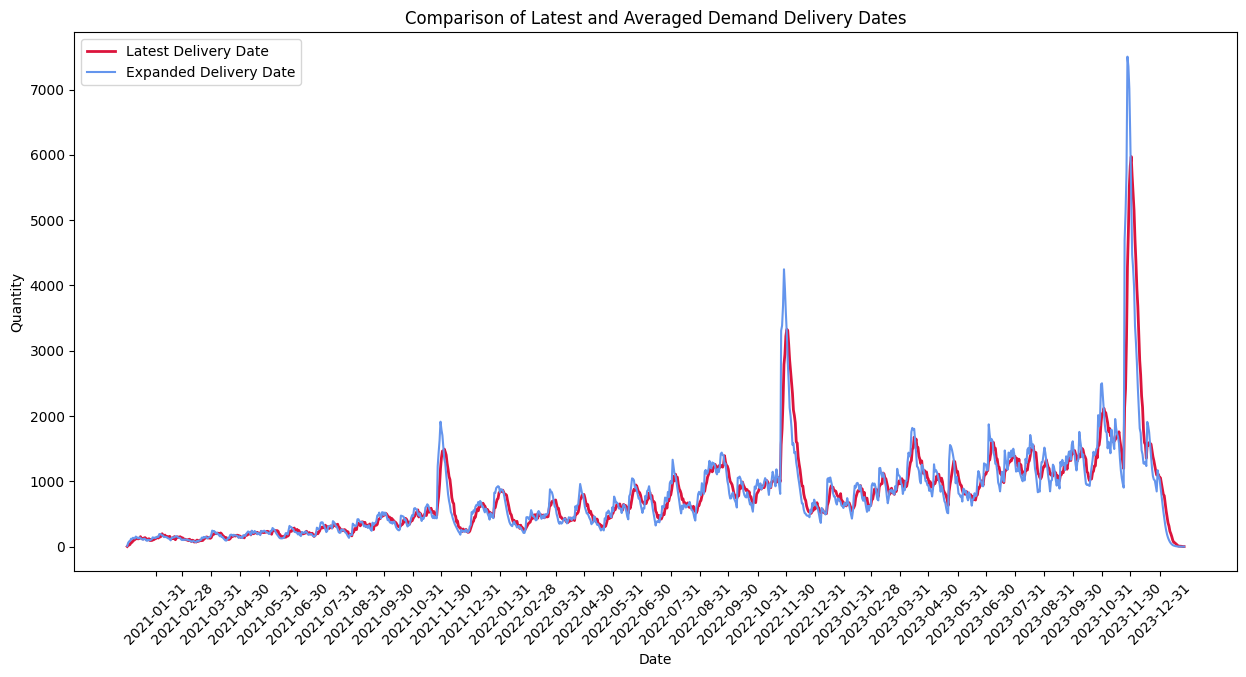

In [50]:
# Create a pivot table to aggregate the quantities by date
pivot_averaged_demand_over_date_range = expanded_df.pivot_table(index='Date', values='Quantity', aggfunc='sum')

#print(f'Total Quantity = {total_quantity}')
#print(pivot_averaged_demand_over_date_range.sum())

plt.figure(figsize=(15, 7))
plt.plot(pivot_latest_delivery_date.index, pivot_latest_delivery_date['Quantity'], label='Latest Delivery Date', color='crimson', linewidth=2)
plt.plot(pivot_averaged_demand_over_date_range.index, pivot_averaged_demand_over_date_range['Quantity'], label='Expanded Delivery Date', color='cornflowerblue')
plt.xlabel('Date')
plt.xticks(pd.date_range(start=pivot_averaged_demand_over_date_range.index.min(), end=pivot_averaged_demand_over_date_range.index.max(), freq='ME'), rotation=45)
plt.ylabel('Quantity')
plt.title('Comparison of Latest and Averaged Demand Delivery Dates')
plt.legend()
plt.show()

This code looks (in the order of the DemandID) at every demand's earliest and latest delivery dates and adds that quantity to the earliest delivery day with the lowest current quantity. It achieves a smoother graph than just using latest delivery date.

Note: this cell can take a while to run.

In [51]:
# Create a DataFrame with the same index as df_demand_log and a column of quantities initialized to 0
quantity_table = pd.DataFrame(index=pd.date_range(start=df_demand_log['Earliest Delivery Date'].min(), 
                                                  end=df_demand_log['Latest Delivery Date'].max()), 
                              columns=['Quantity'])
quantity_table['Quantity'] = 0

# Iterate through each row of df_demand_log
for _, row in df_demand_log.iterrows():
    start_date = row['Earliest Delivery Date']
    end_date = row['Latest Delivery Date']
    quantity = row['Quantity']
    
    # Find the date from start_date to end_date that has the lowest quantity in the table of values
    date_range = pd.date_range(start=start_date, end=end_date)
    min_quantity_date = quantity_table.loc[date_range]['Quantity'].idxmin()
    
    # Add the quantity to that spot
    quantity_table.at[min_quantity_date, 'Quantity'] += quantity

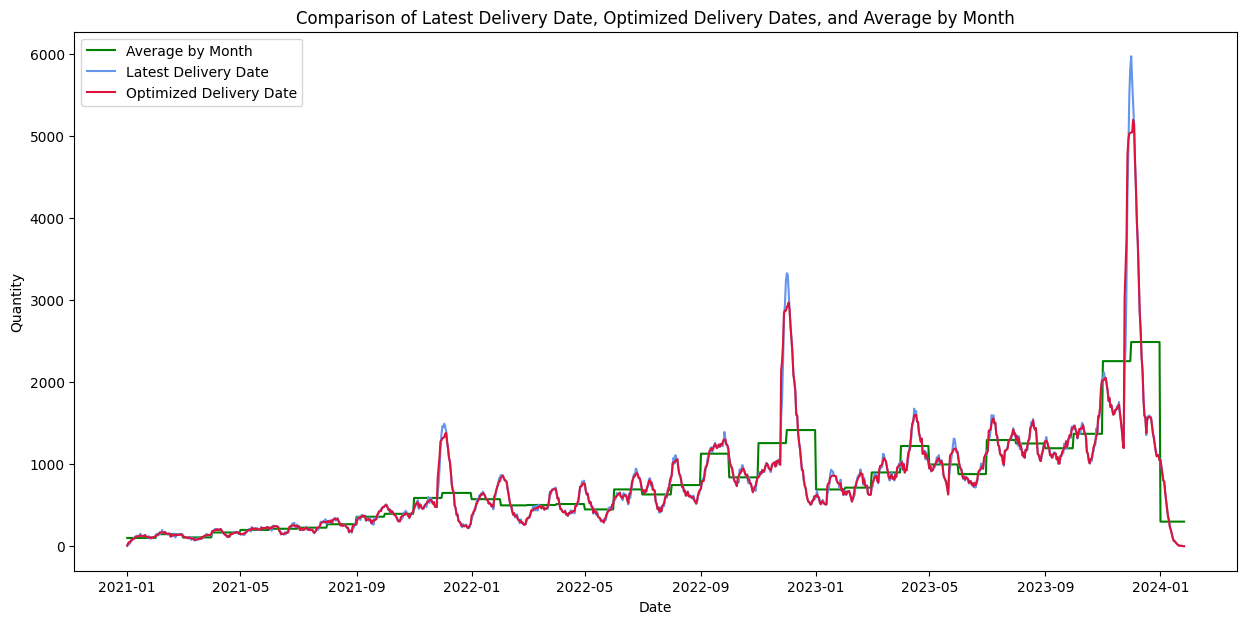

In [52]:
# Convert index to DatetimeIndex
pivot_latest_delivery_date_temp = pivot_latest_delivery_date.copy()
pivot_latest_delivery_date_temp.index = pd.to_datetime(pivot_latest_delivery_date.index)
# Resample the pivot table to monthly
average_quantity_by_month = pivot_latest_delivery_date_temp.resample('ME').mean()

# Refine average quantity by month to make a proper line plot
for i in average_quantity_by_month.index:
    month_start = pd.to_datetime(f'{i.year}-{i.month}-01')
    new_row = pd.DataFrame({'Quantity': [average_quantity_by_month.loc[i, 'Quantity']]}, index=[month_start])
    average_quantity_by_month = pd.concat([average_quantity_by_month, new_row]).sort_index()

average_quantity_by_month.index = average_quantity_by_month.index[:-1].append(pd.to_datetime([last_day]))

plt.figure(figsize=(15, 7))

plt.plot(average_quantity_by_month.index, average_quantity_by_month['Quantity'], label='Average by Month', color='g')
plt.plot(pivot_latest_delivery_date.index, pivot_latest_delivery_date['Quantity'], label='Latest Delivery Date', color='cornflowerblue')
plt.plot(quantity_table.index, quantity_table['Quantity'], label='Optimized Delivery Date', color='crimson')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Comparison of Latest Delivery Date, Optimized Delivery Dates, and Average by Month')
plt.legend()
plt.show()

               Quantity
2021-01-03    32.666667
2021-01-04    32.666667
2021-01-17   103.642857
2021-01-18   103.642857
2021-01-31   114.285714
...                 ...
2024-01-01  1341.285714
2024-01-14   537.071429
2024-01-15   537.071429
2024-01-28    22.166667
2024-01-29    22.166667

[162 rows x 1 columns]


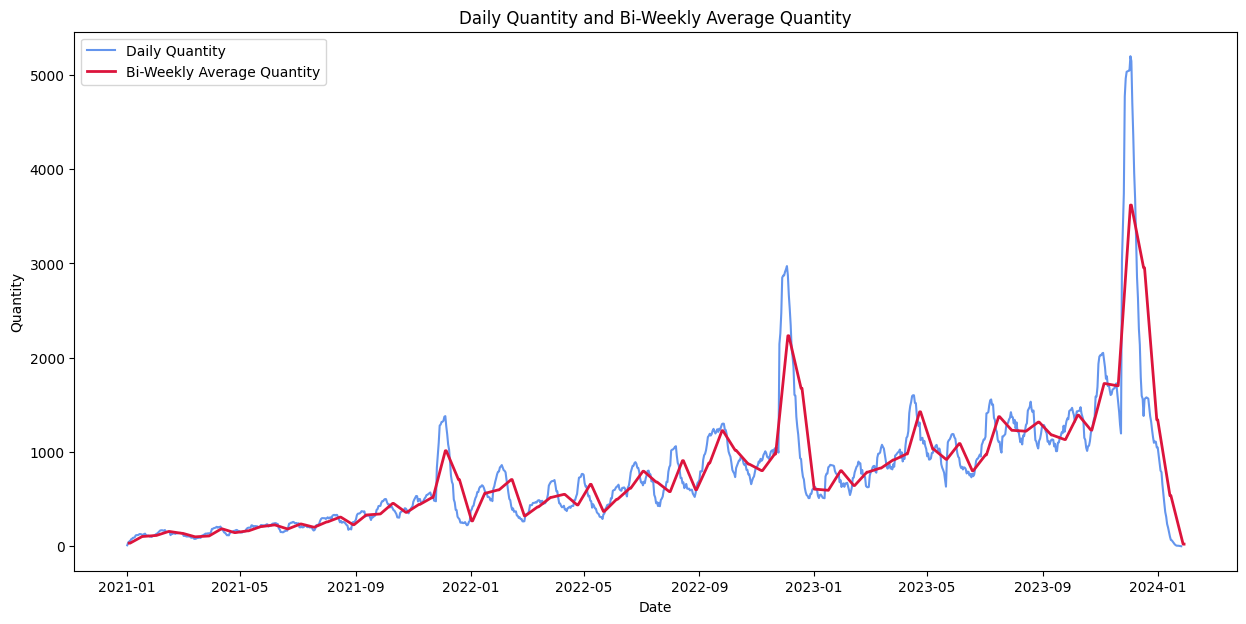

In [53]:
# Resample the quantity_table to bi-weekly (every two weeks)
biweekly_quantity = quantity_table.resample('2W').mean()

# Add an identity entry with a single day increase in time for every entry in biweekly_quantity
biweekly_quantity_shifted = biweekly_quantity.copy()
biweekly_quantity_shifted.index = biweekly_quantity_shifted.index + pd.DateOffset(days=1)
biweekly_quantity = pd.concat([biweekly_quantity, biweekly_quantity_shifted]).sort_index()
print(biweekly_quantity)

# Plot the quantity_table and bi-weekly average
plt.figure(figsize=(15, 7))
plt.plot(quantity_table.index, quantity_table['Quantity'], label='Daily Quantity', color='cornflowerblue')
plt.plot(biweekly_quantity.index, biweekly_quantity['Quantity'], label='Bi-Weekly Average Quantity', color='crimson', linewidth=2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Daily Quantity and Bi-Weekly Average Quantity')
plt.legend()
plt.show()